In [2]:
import os, sys
sys.path.append('../')
os.environ["PYOPENGL_PLATFORM"] = "egl"

import numpy as np
import json
import math

import torch

import open3d as o3d
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib nbagg

In [3]:
def plot_3d_point_cloud(x,
                        y,
                        z,
                        show=True,
                        show_axis=True,
                        in_u_sphere=False,
                        marker='.',
                        s=8,
                        alpha=.8,
                        figsize=(5, 5),
                        elev=10,
                        azim=240,
                        axis=None,
                        title=None,
                        lim=None,
                        *args,
                        **kwargs):

    if axis is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
    else:
        ax = axis
        fig = axis

    if title is not None:
        plt.title(title)

    sc = ax.scatter(x, y, z, marker=marker, s=s, alpha=alpha, *args, **kwargs)
    ax.view_init(elev=elev, azim=azim)

    if lim:
        ax.set_xlim3d(*lim[0])
        ax.set_ylim3d(*lim[1])
        ax.set_zlim3d(*lim[2])
    elif in_u_sphere:
        ax.set_xlim3d(-0.5, 0.5)
        ax.set_ylim3d(-0.5, 0.5)
        ax.set_zlim3d(-0.5, 0.5)
    else:
        lim = (min(np.min(x), np.min(y),
                   np.min(z)), max(np.max(x), np.max(y), np.max(z)))
        ax.set_xlim(1.3 * lim[0], 1.3 * lim[1])
        ax.set_ylim(1.3 * lim[0], 1.3 * lim[1])
        ax.set_zlim(1.3 * lim[0], 1.3 * lim[1])
        plt.tight_layout()

    if not show_axis:
        plt.axis('off')

    if show:
        plt.show()

    return fig

In [4]:
def read_depth(depth_path):
    depth_img = np.array(Image.open(depth_path))
    depth_img = depth_img.astype(np.float32) * 0.001
    print(depth_img.dtype)
    
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(np.empty_like(depth_img)),
        o3d.geometry.Image(depth_img),
        depth_scale=1.0,
        depth_trunc=0.7,
        convert_rgb_to_intensity=False,
    )
    return rgbd

def sum_downsample_points(point_list, voxel_size=0.01, nb_neighbors=20, std_ratio=2.0):
    points = np.concatenate([np.asarray(x.points) for x in point_list], axis=0)
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd = pcd.voxel_down_sample(voxel_size=voxel_size)
    pcd, _ = pcd.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)
    return pcd

In [5]:
def normalize(tensor: torch.Tensor, dim: int) -> torch.Tensor:
    return tensor / ((tensor ** 2).sum(dim, keepdim=True).sqrt() + 1.0e-5)

def vector_to_rotation(vector):
    z = np.array(vector)
    z = z / np.linalg.norm(z)
    x = np.array([1, 0, 0])
    x = x - z*(x.dot(z)/z.dot(z))
    x = x / np.linalg.norm(x)
    y = np.cross(z, x)
    return np.c_[x, y, z]

def add_r_joint_to_scene(scene,
                             axis,
                             pivot_point,
                             length,
                             radius=0.01,
                             joint_color=[200, 0, 0, 180],
                             recenter=False):
    if recenter:
        pivot_point = np.cross(axis, np.cross(pivot_point, axis))
    rotation_mat = vector_to_rotation(axis)
    screw_tran = np.eye(4)
    screw_tran[:3, :3] = rotation_mat
    screw_tran[:3, 3] = pivot_point
    
    axis_cylinder = trimesh.creation.cylinder(radius, height=length)
    axis_arrow = trimesh.creation.cone(radius * 2, radius * 4)
    arrow_trans = np.eye(4)
    arrow_trans[2, 3] = length / 2
    axis_arrow.apply_transform(arrow_trans)
    axis_obj = trimesh.Scene((axis_cylinder, axis_arrow))
    screw = as_mesh(axis_obj)
    
    # screw.apply_translation([0, 0, 0.1])
    screw.apply_transform(screw_tran)
    screw.visual.face_colors = np.array(joint_color, dtype=np.uint8)
    scene.add_geometry(screw)
    return screw

# load data

In [10]:
# crop out the object
bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=(0.5, -0.22, -0.03), max_bound=(1.2, 0.3, 0.6))
# print(bbox)

pcd_1 = o3d.io.read_point_cloud('angle1.pcd')
pcd_2 = o3d.io.read_point_cloud('angle2.pcd')
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.05, origin=[0]*3)
o3d.visualization.draw_geometries([pcd_1, mesh_frame, bbox])
pcd_1 = pcd_1.crop(bbox)
pcd_2 = pcd_2.crop(bbox)


# find bounding box of data
src_pc_list = []
src_fused_pc = np.asarray(pcd_1.points)
center = (np.min(src_fused_pc, 0) + np.max(src_fused_pc, 0)) / 2
scale = (np.max(src_fused_pc, 0) - np.min(src_fused_pc, 0)).max()
scale *= 1.1

# back project and normalize point cloud

src_pcd_list = []
pcd = pcd_1
center_transform = np.eye(4)
center_transform[:3, 3] = -center
pcd.transform(center_transform)
pcd.scale(1 / scale, np.zeros((3, 1)))
src_pcd_list.append(pcd)
    
dst_pcd_list = []
pcd = pcd_2
center_transform = np.eye(4)
center_transform[:3, 3] = -center
pcd.transform(center_transform)
pcd.scale(1 / scale, np.zeros((3, 1)))
dst_pcd_list.append(pcd)
    
src_pcd = sum_downsample_points(src_pcd_list, 0.02, 50, 0.1)
dst_pcd = sum_downsample_points(dst_pcd_list, 0.02, 50, 0.1)

In [11]:
# visualize crop results
# tune crop box to get better isolated objects
o3d.visualization.draw_geometries([src_pcd])
o3d.visualization.draw_geometries([dst_pcd])
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot_3d_point_cloud(*np.asarray(src_pcd.points).T,
                    axis=ax,
                    azim=30,
                    elev=30,
                    lim=[(-0.5, 0.5)] * 3)

ax = fig.add_subplot(1, 2, 2, projection='3d')
plot_3d_point_cloud(*np.asarray(dst_pcd.points).T,
                    axis=ax,
                    azim=30,
                    elev=30,
                    lim=[(-0.5, 0.5)] * 3)

plt.show()

<IPython.core.display.Javascript object>

# Run model

In [12]:
import torch
from hydra.experimental import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
import hydra

from src.third_party.ConvONets.conv_onet.generation_two_stage import Generator3D
from src.utils.misc import sample_point_cloud

In [13]:
with initialize(config_path='../configs/'):
    config = compose(
        config_name='config',
        overrides=[
            'experiment=sapien_different_pose_angle_stereo_depth.yaml',
        ], return_hydra_config=True)
config.datamodule.opt.train.data_dir = '../data/'
config.datamodule.opt.val.data_dir = '../data/'
config.datamodule.opt.test.data_dir = '../data/'

/home/xulab10/miniconda3/envs/Ditto/lib/python3.8/site-packages/hydra/experimental/initialize.py:35: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  warnings.warn(
/home/xulab10/miniconda3/envs/Ditto/lib/python3.8/site-packages/hydra/experimental/compose.py:16: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  warnings.warn(


In [24]:
model = hydra.utils.instantiate(config.model)
# ckpt = torch.load('/home/xulab10/Ditto/logs/runs/2022-05-25/sapien_different_angle_stereo_depth-21-09-36/checkpoints/epoch_564.ckpt')
# ckpt = torch.load('/home/xulab10/Ditto/logs/runs/2022-05-26/sapien_different_pose_angle_stereo_depth-11-56-09/checkpoints/epoch_321.ckpt')
ckpt = torch.load('/home/xulab10/Ditto/logs/runs/2022-05-30/sapien_different_pose_angle_stereo_depth-18-57-03/checkpoints/epoch_322.ckpt')

# ckpt = torch.load('/home/xulab10/Ditto/logs/runs/2022-05-25/sapien_different_angle_stereo_depth-21-09-36/checkpoints/epoch_564.ckpt')
device = torch.device(0)
model.load_state_dict(ckpt['state_dict'], strict=True)
model = model.eval().to(device)

In [25]:
generator = Generator3D(
    model.model,
    device=device,
    threshold=0.4,
    seg_threshold=0.5,
    input_type='pointcloud',
    refinement_step=0,
    padding=0.1,
    resolution0=32
)

In [26]:
pc_start = np.asarray(src_pcd.points)
pc_end = np.asarray(dst_pcd.points)

bound_max = np.maximum(pc_start.max(0), pc_end.max(0))
bound_min = np.minimum(pc_start.min(0), pc_end.min(0))
norm_center = (bound_max + bound_min) / 2
norm_scale = (bound_max - bound_min).max() * 1.1
pc_start = (pc_start - norm_center) / norm_scale
pc_end = (pc_end - norm_center) / norm_scale

pc_start, _ = sample_point_cloud(pc_start, 8192)
pc_end, _ = sample_point_cloud(pc_end, 8192)
sample = {
    'pc_start': torch.from_numpy(pc_start).unsqueeze(0).to(device).float(),
    'pc_end': torch.from_numpy(pc_end).unsqueeze(0).to(device).float()
}

In [27]:
mesh_dict, mobile_points_all, c, stats_dict = generator.generate_mesh(sample)
with torch.no_grad():
    joint_type_logits, joint_param_revolute, joint_param_prismatic = model.model.decode_joints(mobile_points_all, c)

# Visualize results

In [28]:
import trimesh
from src.utils.joint_estimation import aggregate_dense_prediction_r

from utils3d.mesh.utils import as_mesh
from utils3d.utils.utils import get_pose
from utils3d.render.pyrender import PyRenderer
import cv2

In [34]:
renderer = PyRenderer(light_kwargs={'color': np.array([1., 1., 1.]), 'intensity': 9})

In [35]:
# compute articulation model
mesh_dict[1].visual.face_colors = np.array([84, 220, 83, 255], dtype=np.uint8)
joint_type_prob = joint_type_logits.sigmoid().mean()

if joint_type_prob.item()< 0.5:
    # axis voting
    joint_r_axis = (
        normalize(joint_param_revolute[:, :, :3], -1)[0].cpu().numpy()
    )
    joint_r_t = joint_param_revolute[:, :, 3][0].cpu().numpy()
    joint_r_p2l_vec = (
        normalize(joint_param_revolute[:, :, 4:7], -1)[0].cpu().numpy()
    )
    joint_r_p2l_dist = joint_param_revolute[:, :, 7][0].cpu().numpy()
    p_seg = mobile_points_all[0].cpu().numpy()

    pivot_point = p_seg + joint_r_p2l_vec * joint_r_p2l_dist[:, np.newaxis]
    (
        joint_axis_pred,
        pivot_point_pred,
        config_pred,
    ) = aggregate_dense_prediction_r(
        joint_r_axis, pivot_point, joint_r_t, method="mean"
    )
# prismatic
else:
    # axis voting
    joint_p_axis = (
        normalize(joint_param_prismatic[:, :, :3], -1)[0].cpu().numpy()
    )
    joint_axis_pred = joint_p_axis.mean(0)
    joint_p_t = joint_param_prismatic[:, :, 3][0].cpu().numpy()
    config_pred = joint_p_t.mean()
    
    pivot_point_pred = mesh_dict[1].bounds.mean(0)

In [36]:
scene = trimesh.Scene()
static_part = mesh_dict[0].copy()
mobile_part = mesh_dict[1].copy()
scene.add_geometry(static_part)
scene.add_geometry(mobile_part)
add_r_joint_to_scene(scene, joint_axis_pred, pivot_point_pred, 1.0, recenter=True)

<trimesh.Trimesh(vertices.shape=(100, 3), faces.shape=(192, 3))>

In [37]:
# render result mesh
pose = get_pose(1.5, ax=np.pi / 3, ay=0, az=-1*np.pi/4)
camera_pose = pose
light_pose = pose
rgb, depth = renderer.render_mesh(scene, camera_pose, light_pose)

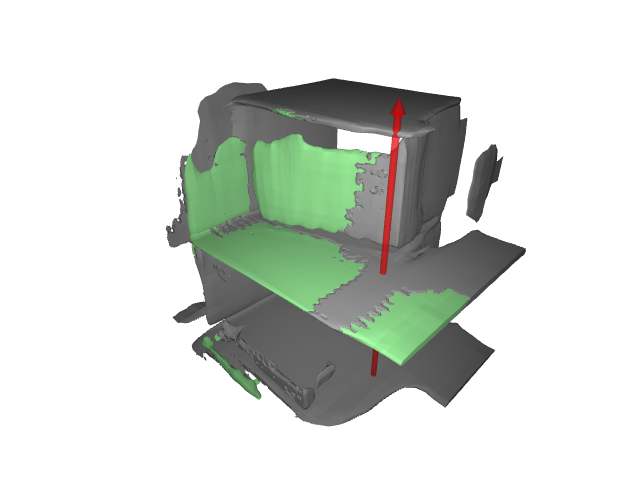

In [38]:
Image.fromarray(rgb)